In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
 
%matplotlib inline
tf.random.set_seed(42)

In [4]:
df = pd.read_csv('C:/Niveda/Jupyter projects/Mhealth_full/mhealth_raw_data.csv')
df

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.449020,-1.01030,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.449020,-1.01030,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.449020,-1.01030,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.456860,-1.00820,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.456860,-1.00820,0.025862,0,subject1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,1.7849,-9.8287,0.29725,-0.341370,-0.90056,-0.61493,-3.7198,-8.9071,0.294230,0.041176,-0.99384,-0.480600,0,subject10
1215741,1.8687,-9.8766,0.46236,-0.341370,-0.90056,-0.61493,-3.7160,-8.7455,0.448140,0.041176,-0.99384,-0.480600,0,subject10
1215742,1.6928,-9.9290,0.16631,-0.341370,-0.90056,-0.61493,-3.8824,-9.1155,0.450480,0.041176,-0.99384,-0.480600,0,subject10
1215743,1.5279,-9.6306,0.30458,-0.341370,-0.90056,-0.61493,-3.5564,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0,subject10


In [5]:
from sklearn.utils import resample
 
df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]
 
df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [6]:
df1 = df.copy()
for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)
  print(feature,'range:',lower_range,'to',upper_range)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)
  print('shape',df1.shape)

alx range: -11.47312 to 19.233
shape (365733, 14)
aly range: -19.379 to 2.447871999999997
shape (360018, 14)
alz range: -18.95 to 14.19623999999999
shape (356270, 14)
glx range: -0.74212 to 0.80705
shape (349377, 14)
gly range: -1.0694 to 0.96623
shape (342841, 14)
glz range: -1.1061 to 0.8290799999999999
shape (337391, 14)
arx range: -21.492 to 9.097647999999998
shape (332307, 14)
ary range: -18.694000000000003 to 11.948059999999998
shape (326241, 14)
arz range: -10.367 to 11.823119999999996
shape (323674, 14)
grx range: -1.0196 to 0.95686
shape (320188, 14)
gry range: -1.1417 to 0.90965
shape (315352, 14)
grz range: -0.69828 to 1.125
shape (310929, 14)


In [7]:
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

In [8]:
print(df1.shape)
train = df1[(df1['subject'] != 'subject10') & (df1['subject'] != 'subject9')]
test = df1.drop(train.index, axis=0)
train.shape,test.shape
#taking subject 9 and 10 as test data

(310929, 14)


((246501, 14), (64428, 14))

In [9]:
X_train = train.drop(['Activity','subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity','subject'],axis=1)
y_test = test['Activity']
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((246501, 12), (246501,), (64428, 12), (64428,))

In [10]:
from scipy import stats

#function to create time series datset for seuence modeling
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [11]:
X_train,y_train = create_dataset(X_train, y_train, 100, step=50)
X_train.shape, y_train.shape

C:\Users\nived\AppData\Local\Temp\ipykernel_18064\1935378417.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])


((4929, 100, 12), (4929, 1))

In [12]:
X_test,y_test = create_dataset(X_test, y_test, 100, step=50)
X_test.shape, y_test.shape

C:\Users\nived\AppData\Local\Temp\ipykernel_18064\1935378417.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])


((1287, 100, 12), (1287, 1))

In [43]:
model = keras.Sequential()
model.add(layers.Input(shape=[100,12]))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.LSTM(64))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 100, 32)           1184      
                                                                 
 batch_normalization_5 (Batc  (None, 100, 32)          128       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 100, 32)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 100, 64)           6208      
                                                                 
 batch_normalization_6 (Batc  (None, 100, 64)          256       
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 100, 64)          

In [44]:
callbacks = [keras.callbacks.ModelCheckpoint("mhealth_best.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]
 
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)
 
model_history = model.fit(X_train,y_train, epochs= 10, validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/10
155/155 [==============================] - 8s 36ms/step - loss: 0.9138 - sparse_categorical_accuracy: 0.7060 - val_loss: 2.5283 - val_sparse_categorical_accuracy: 0.3893
Epoch 2/10
155/155 [==============================] - 6s 36ms/step - loss: 0.2756 - sparse_categorical_accuracy: 0.9093 - val_loss: 0.7932 - val_sparse_categorical_accuracy: 0.7343
Epoch 3/10
155/155 [==============================] - 6s 36ms/step - loss: 0.2062 - sparse_categorical_accuracy: 0.9345 - val_loss: 0.1785 - val_sparse_categorical_accuracy: 0.9503
Epoch 4/10
155/155 [==============================] - 6s 36ms/step - loss: 0.1389 - sparse_categorical_accuracy: 0.9596 - val_loss: 0.0951 - val_sparse_categorical_accuracy: 0.9744
Epoch 5/10
155/155 [==============================] - 6s 36ms/step - loss: 0.1225 - sparse_categorical_accuracy: 0.9619 - val_loss: 0.3224 - val_sparse_categorical_accuracy: 0.9332
Epoch 6/10
155/155 [==============================] - 6s 36ms/step - loss: 0.1179 - sparse_cate

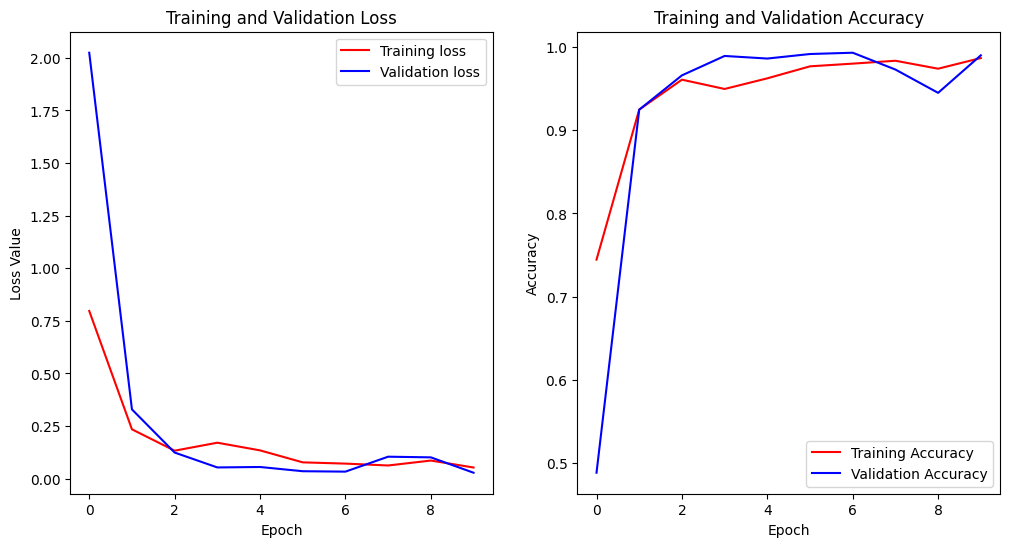

In [17]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['sparse_categorical_accuracy']
val_accuracy = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
model = keras.models.load_model('./mhealth_best.h5')

train_loss, train_acc = model.evaluate(X_train,y_train)
test_loss, test_acc = model.evaluate(X_test,y_test)

print("Train accuracy", round(train_acc*100, 2),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 2),'%')
print("Test loss", test_loss)

41/41 [==============================] - 0s 11ms/step - loss: 0.0280 - sparse_categorical_accuracy: 0.9899
Train accuracy 99.51 %
Train loss 0.017970645800232887
Test accuracy 98.99 %
Test loss 0.027989592403173447


In [19]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
pred = pred.reshape(-1,1)

41/41 [==============================] - 1s 10ms/step


In [20]:
pred.shape,y_test.shape

((1287, 1), (1287, 1))

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
 
print(classification_report(y_test,pred))
print('*'*50)
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        92
           1       0.99      0.99      0.99       123
           2       0.99      0.99      0.99       123
           3       1.00      0.99      1.00       122
           4       0.99      1.00      1.00       120
           5       1.00      1.00      1.00        84
           6       0.96      0.97      0.97       106
           7       0.99      0.99      0.99       112
           8       0.99      0.97      0.98       116
           9       0.99      0.99      0.99       121
          10       0.98      1.00      0.99        89
          11       1.00      0.98      0.99        52
          12       1.00      1.00      1.00        27

    accuracy                           0.99      1287
   macro avg       0.99      0.99      0.99      1287
weighted avg       0.99      0.99      0.99      1287

**************************************************
[[ 92   0   0   0   0   0   

In [26]:
from keras.models import Sequential,Model
from keras.layers import Conv2D,Conv1D
from keras.layers import MaxPooling2D,MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense,SimpleRNN,Dropout,Reshape
import tensorflow as tf

In [68]:
feature_extractor = keras.Sequential()
feature_extractor.add(layers.Input(shape=[100,12]))
feature_extractor.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
feature_extractor.add(layers.BatchNormalization())
feature_extractor.add(layers.ReLU())
feature_extractor.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
feature_extractor.add(layers.BatchNormalization())
feature_extractor.add(layers.ReLU())
feature_extractor.add(layers.MaxPool1D(2))
feature_extractor.add(layers.LSTM(64))
feature_extractor.add(Dense(units=128, activation='relu'))

In [69]:
x=feature_extractor.output
#x=Dense(units=128, activation='relu')(x)
prediction_layer=Dense(13, activation='softmax')(x)

In [70]:
cnn_model=Model(inputs=feature_extractor.input,outputs=prediction_layer)
cnn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)
cnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 100, 32)           1184      
                                                                 
 batch_normalization_7 (Batc  (None, 100, 32)          128       
 hNormalization)                                                 
                                                                 
 re_lu_6 (ReLU)              (None, 100, 32)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 100, 64)           6208      
                                                                 
 batch_normalization_8 (Batc  (None, 100, 64)          256       
 hNormalization)                                           

In [71]:
history=cnn_model.fit(X_train,y_train, epochs= 10, validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/10
155/155 [==============================] - 11s 47ms/step - loss: 0.7319 - sparse_categorical_accuracy: 0.7744 - val_loss: 2.0256 - val_sparse_categorical_accuracy: 0.5144
Epoch 2/10
155/155 [==============================] - 6s 41ms/step - loss: 0.1772 - sparse_categorical_accuracy: 0.9462 - val_loss: 0.3384 - val_sparse_categorical_accuracy: 0.8679
Epoch 3/10
155/155 [==============================] - 5s 34ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.9560 - val_loss: 0.4756 - val_sparse_categorical_accuracy: 0.8430
Epoch 4/10
155/155 [==============================] - 5s 33ms/step - loss: 0.0938 - sparse_categorical_accuracy: 0.9732 - val_loss: 0.3767 - val_sparse_categorical_accuracy: 0.8516
Epoch 5/10
155/155 [==============================] - 5s 33ms/step - loss: 0.0864 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.5194 - val_sparse_categorical_accuracy: 0.9052
Epoch 6/10
155/155 [==============================] - 5s 33ms/step - loss: 0.1706 - sparse_cat

In [72]:
X_for_RF=feature_extractor.predict(X_train)

155/155 [==============================] - 3s 15ms/step


In [73]:
X_for_RF.shape

(4929, 128)

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
RF_model = RandomForestClassifier(random_state=42, n_estimators=50)
RF_model = RF_model.fit(X_for_RF, y_train.ravel())

In [75]:
X_test_feature=feature_extractor.predict(X_test)
prediction_RF=RF_model.predict(X_test_feature)

41/41 [==============================] - 1s 16ms/step


In [76]:
print(accuracy_score(y_test,prediction_RF)) 

0.9432789432789432


In [77]:
from sklearn import svm
svmclf=svm.SVC()
svmclf.fit(X_for_RF,y_train.ravel())

SVC()

In [78]:
X_test_feature=feature_extractor.predict(X_test)
prediction_svm=svmclf.predict(X_test_feature)

41/41 [==============================] - 1s 15ms/step


In [79]:
print(accuracy_score(y_test,prediction_svm)) 

0.9906759906759907


In [86]:
X_train_feature_train=feature_extractor.predict(X_train)
prediction_svm_train=svmclf.predict(X_train_feature_train)

155/155 [==============================] - 3s 16ms/step


In [87]:
print(accuracy_score(y_train,prediction_svm_train)) 

0.9955366200040576
